Uncomment and run the cell below if you are in a Google Colab environment. It will:
1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the hello_world example
7. Install requirements.

This means that any modifications will be saved, and you won't lose them if you close your browser.

In [1]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton/
## 6. Move your current directory to the hello_world example
# %cd hamilton/examples/hello_world
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [4]:
# Cell 2 - import modules to create part of the DAG from
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

In [9]:
from __future__ import annotations

import importlib
import logging
import sys
from types import ModuleType
from typing import Any, Dict, List

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_array, check_is_fitted

from hamilton import base, driver, log_setup, ad_hoc_utils

logger = logging.getLogger(__name__)
log_setup.setup_logging()

In [5]:
# We'll place the spend calculations into a new module

def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


spend_calculations = ad_hoc_utils.create_temporary_module(
    avg_3wk_spend, spend_per_signup, module_name="spend_calculations"
)


In [6]:
# We'll place the spend statistics calculations into a new module

def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev


spend_statistics = ad_hoc_utils.create_temporary_module(
    spend_mean, spend_zero_mean, spend_std_dev, spend_zero_mean_unit_variance, module_name="spend_statistics"
)


In this example we show you a custom scikit-learn `Transformer` class. This class should be compliant with [scikit-learn transformers specifications](https://scikit-learn.org/stable/developers/develop.html). This class is meant to be used as part of broader scikit-learn pipelines. Scikit-learn estimators and pipelines allow for stateful objects, which are helpful when applying transformations on train-test splits notably. Also, all pipeline, estimator, and transformer objects should be picklable, enabling reproducible pipelines.

In [8]:
class HamiltonTransformer(BaseEstimator, TransformerMixin):
    """Scikit-learn compatible Transformer implementing Hamilton behavior"""

    def __init__(
        self,
        config: dict = None,
        modules: List[ModuleType] = None,
        adapter: base.HamiltonGraphAdapter = None,
        final_vars: List[str] = None,
    ):
        self.config = {} if config is None else config
        self.modules = [] if modules is None else modules
        self.adapter = adapter
        self.final_vars = [] if final_vars is None else final_vars

    def get_params(self) -> dict:
        """Get parameters for this estimator.

        :return: Current parameters of the estimator
        """
        return {
            "config": self.config,
            "modules": self.modules,
            "adapter": self.adapter,
            "final_vars": self.final_vars,
        }

    def set_params(self, **parameters) -> HamiltonTransformer:
        """Get parameters for this estimator.

        :param parameters: Estimator parameters.
        :return: self
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_features_names_out(self):
        """"""
        if self.feature_names_out_:
            return self.feature_names_out_

    def _get_tags(self) -> dict:
        """Get scikit-learn compatible estimator tags for introspection

        ref: https://scikit-learn.org/stable/developers/develop.html#estimator-tags
        """
        return {"requires_fit": True, "requires_y": False}

    def fit(self, X, y=None, overrides: Dict[str, Any] = None) -> HamiltonTransformer:
        """Instantiate Hamilton driver.Driver object

        :param X: Input 2D array
        :param overrides: dictionary of override values passed to driver.execute() during .transform()
        :return: self
        """

        check_array(X, accept_sparse=True)
        self.overrides_ = {} if overrides is None else overrides

        self.driver_ = driver.Driver(self.config, *self.modules, adapter=self.adapter)
        self.n_features_in_: int = X.shape[1]

        return self

    def transform(self, X, y=None, **kwargs) -> pd.DataFrame:
        """Execute Hamilton Driver on X with optional parameters fit_params and returns a
        transformed version of X. Requires prior call to .fit() to instantiate Hamilton Driver

        :param X: Input 2D array
        :return: Hamilton Driver output 2D array
        """

        check_is_fitted(self, "n_features_in_")

        if isinstance(X, pd.DataFrame):
            check_array(X, accept_sparse=True)
            if X.shape[1] != self.n_features_in_:
                raise ValueError("Shape of input is different from what was seen in `fit`")

            X = X.to_dict(orient="series")

        X_t = self.driver_.execute(final_vars=self.final_vars, overrides=self.overrides_, inputs=X)
        # self.driver_.visualize_execution(final_vars=self.final_vars,
        #                                  output_file_path="./scikit_transformer",
        #                                  render_kwargs={"format": "png"},
        #                                  inputs=X)
        self.n_features_out_ = len(self.final_vars)
        self.feature_names_out_ = X_t.columns.to_list()
        return X_t

    def fit_transform(self, X, y=None, **fit_params) -> pd.DataFrame:
        """Execute Hamilton Driver on X with optional parameters fit_params and returns a
        transformed version of X.

        :param X: Input 2D array
        :return: Hamilton Driver output 2D array
        """
        return self.fit(X, **fit_params).transform(X)


In [10]:
# Set up the driver, input and output columns
initial_df = pd.DataFrame(
    {"signups": [1, 10, 50, 100, 200, 400], "spend": [10, 10, 20, 40, 40, 50]}
)

output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]


dr = driver.Driver({}, spend_calculations,spend_statistics)


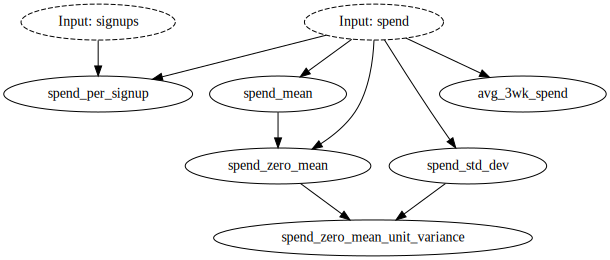

In [14]:
# Visualize execution
# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work

# visualize all possible functions
dr.display_all_functions(output_file_path=None)

Check 1: output of `vanilla driver` == `custom transformer`

In [16]:

hamilton_df = dr.execute(final_vars=output_columns, inputs=initial_df.to_dict(orient="series"))

custom_transformer = HamiltonTransformer(
    config={}, modules=[spend_calculations, spend_statistics], final_vars=output_columns)
sklearn_df = custom_transformer.fit_transform(initial_df)

try:
    pd.testing.assert_frame_equal(sklearn_df, hamilton_df)

except ValueError as e:
    logger.warning("Check 1 failed; `sklearn_df` and `hamilton_df` are unequal")
    raise e


Check 2: output of `vanilla driver >> transformation` == `scikit-learn pipeline`

In [17]:
scaler = StandardScaler()

hamilton_df = dr.execute(final_vars=output_columns, inputs=initial_df.to_dict(orient="series"))
hamilton_then_sklearn = scaler.fit_transform(hamilton_df)

pipeline1 = Pipeline(steps=[("hamilton", custom_transformer), ("scaler", scaler)])
pipe_custom_then_sklearn = pipeline1.fit_transform(initial_df)
try:
    assert isinstance(hamilton_then_sklearn, np.ndarray)
    assert isinstance(pipe_custom_then_sklearn, np.ndarray)

    np.testing.assert_equal(pipe_custom_then_sklearn, hamilton_then_sklearn)

except ValueError as e:
    logger.warning(
        "Check 2 failed; `pipe_custom_then_sklearn` and `hamilton_then_sklearn` are unequal"
    )
    raise e


Check 3: output of `transformation >> vanilla driver` == `scikit-learn pipeline`
The custom transformer requires a DataFrame, we leverage the `.set_output` from scikit-learn v1.2
ref: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep018/proposal.html

In [18]:

scaler = StandardScaler().set_output(transform="pandas")

scaled_df = scaler.fit_transform(initial_df)
sklearn_then_hamilton = dr.execute(
    final_vars=output_columns, inputs=scaled_df.to_dict(orient="series")
)

pipeline2 = Pipeline(steps=[("scaler", scaler), ("hamilton", custom_transformer)])
pipe_sklearn_then_custom = pipeline2.fit_transform(initial_df)

try:
    assert isinstance(sklearn_then_hamilton, pd.DataFrame)
    assert isinstance(pipe_sklearn_then_custom, pd.DataFrame)

    pd.testing.assert_frame_equal(pipe_sklearn_then_custom, sklearn_then_hamilton)
except ValueError as e:
    logger.warning(
        "Check 3 failed; `pipe_sklearn_then_custom` and `sklearn_then_hamilton` are unequal"
    )
    raise e

logger.info("All checks passed. `HamiltonTransformer` behaves properly")


Before continuing with using hamilton with scikit-learn please be aware of its possible limitations [here](https://github.com/DAGWorks-Inc/hamilton/tree/main/examples/scikit-learn#limitations-and-todos).